# 0.2 Task


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import ssl
import copy
from sklearn import metrics
import numpy as np
import math
import matplotlib.pyplot as plt
ssl._create_default_https_context = ssl._create_unverified_context

print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)


True
cuda:0


In [15]:
# Define the mini-batch size
if device == "cuda:0":
    batch_size = 15 #Can use higher batch size on cpu
else: 
    batch_size = 750
    
# Download the dataset and create the dataloaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(64),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
#Load all train:
cifar_full = datasets.CIFAR10("./", train=True, download=True, transform=transform)

#Split training, validation
cifar_train, cifar_validation = torch.utils.data.random_split(cifar_full, [0.8, 0.2])
train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=False)
if device == "cuda:0":
    batch_size_validation = 15
else:
    batch_size_validation = len(cifar_validation)
validation_loader = DataLoader(cifar_validation, batch_size=batch_size_validation, shuffle=False)

#Load test:
cifar_test = datasets.CIFAR10("./", train=False, download=True, transform=transform)
if device == "cuda:0":
    batch_size_test = 15
else:
    batch_size_test = len(cifar_test)
test_loader = DataLoader(cifar_test, batch_size=batch_size_test, shuffle=False)

print('Length training set: ', len(cifar_train))
print('Length validation set: ', len(cifar_validation))
print('Length test set: ', len(cifar_test))

def plot_image(image):
    image = np.transpose(image,[1,2,0])
    #print(image.shape)
    plt.figure(figsize=(1,1))
    plt.imshow(image)
    plt.show()
    
def accuracy_func(loader, model):
    total = 0
    correct = 0
    for bacth_nr, (images, labels) in enumerate(loader):
        images,labels = images.to(device), labels.to(device)
        predictions = model.forward(images)
        predictions = torch.argmax(predictions, dim=-1)
        for i in range(len(images)):
            if labels[i] == predictions[i]:
                correct += 1
            total += 1
    accuracy = correct/total
    return accuracy

Files already downloaded and verified
Files already downloaded and verified
Length training set:  40000
Length validation set:  10000
Length test set:  10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


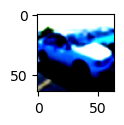

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


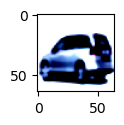

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


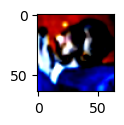

In [16]:
images,labels = next(iter(train_loader))
i = 0
plot_image(images[i])
#print(images[i])
#print(labels[i])
print(images[i].shape)


images,labels = next(iter(validation_loader))
plot_image(images[0])
#print(images[0].shape)

images,labels = next(iter(test_loader))
plot_image(images[0])


In [17]:
to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)
def train_model(model, criterion, optimizer, train_loader, validation_loader, num_epochs, printLoss=10):
    min_validation_loss = 10000    
    # Store training and validation loss
    training_loss, validation_loss = [], []
    for i in range(epochs):

        epoch_validation_loss = 0
        for batch_nr, (images, labels) in enumerate(validation_loader):
        
            labels = to_onehot(labels)
            
            images, labels = images.to(device), labels.to(device)
        
            prediction = model.forward(images)
            
            loss = criterion(prediction, labels)

            epoch_validation_loss += loss.item()
            
        validation_loss.append(epoch_validation_loss/(batch_nr+1))

        if validation_loss[i] < min_validation_loss:
            min_validation_loss = validation_loss[i]
            optModel = copy.deepcopy(model)
            minValLossEpoch = i
            #print(i)

        k = 0
        epoch_training_loss = 0
        for batch_nr, (images, labels) in enumerate(train_loader):
            k += 1
            labels = to_onehot(labels)
            
            images, labels = images.to(device), labels.to(device)

            prediction = model.forward(images)

            loss = criterion(prediction, labels)

            loss.backward()

            optimizer.step()

            optimizer.zero_grad()

            epoch_training_loss += loss.item()
            
        training_loss.append(epoch_training_loss/k)
        
        if i % printLoss == 0:
            print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')
            
    plt.figure(figsize=(6,5))
    plt.plot(range(1,epochs+1), training_loss, 'r', label='Training loss',)
    plt.plot(range(1,epochs+1), validation_loss, 'b', label='Validation loss')
    plt.plot((minValLossEpoch+1,minValLossEpoch+1),(0,max(training_loss+validation_loss)),'k-',label='Best model') 
    plt.legend()
    plt.xlabel('Epoch'), plt.ylabel('Loss')
    plt.grid()
    #plt.ylim((0, 1)) 
    plt.show()
    return optModel

## 0.2.1 Transfer Learning from ImageNet

### Fine tuning:


Using cache found in C:\Users\Simon/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch 0, training loss: 1.069816402847909, validation loss: 3.8755998593577736
Epoch 1, training loss: 0.7692415440307716, validation loss: 0.8559481003607946
Epoch 2, training loss: 0.6459692311691442, validation loss: 0.782570904732376
Epoch 3, training loss: 0.559295016276309, validation loss: 0.7337647231443711
Epoch 4, training loss: 0.4884188632838034, validation loss: 0.7150899170153681
Epoch 5, training loss: 0.4290676845840336, validation loss: 0.6941954524408485
Epoch 6, training loss: 0.3715294923956, validation loss: 0.70692913943547
Epoch 7, training loss: 0.3214062600552667, validation loss: 0.7184725551401032
Epoch 8, training loss: 0.2772169949554597, validation loss: 0.7348866193447782
Epoch 9, training loss: 0.23696046576148683, validation loss: 0.7867660323420408


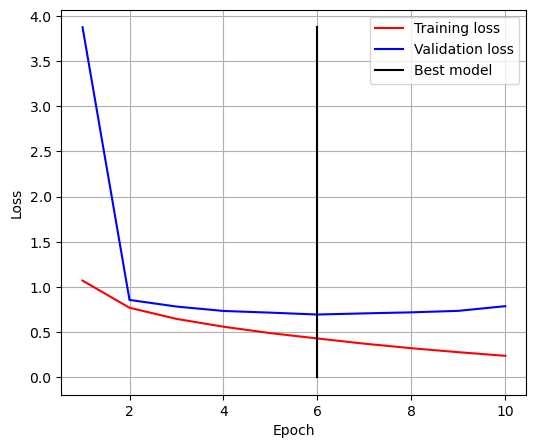

In [18]:
model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained = 'true')

# Do the things required for fine-tuning before training the model
num_classes = len(cifar_full.classes)
#print(model_ft.parameters)
#model_ft_current = model_ft.classifier
model_ft.classifier = nn.Sequential(
    model_ft.classifier,
    nn.ReLU(),
    nn.Linear(1000,num_classes)
)
#print(model_ft.parameters)
model_ft = model_ft.to(device)

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0
epochs = 10
criterion_ft = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), LEARNING_RATE, weight_decay = WEIGHT_DECAY) 

# Train the model
trained_model_ft = train_model(model_ft, criterion_ft, optimizer_ft, train_loader, validation_loader, epochs,1)

# Test the model
tested_model = copy.deepcopy(trained_model_ft)

In [19]:
#Accuracies:
accuracy = accuracy_func(train_loader, tested_model)
print(f'Accuracy, dataset_train: {accuracy*1e2}%')

accuracy = accuracy_func(validation_loader, tested_model)
print(f'Accuracy, dataset_validation: {accuracy*1e2}%')

accuracy = accuracy_func(test_loader, tested_model)
print(f'Accuracy, dataset_test: {accuracy*1e2}%')

Accuracy, dataset_train: 84.405%
Accuracy, dataset_validation: 76.48%
Accuracy, dataset_test: 76.03999999999999%


### Feature extraction

Using cache found in C:\Users\Simon/.cache\torch\hub\pytorch_vision_v0.10.0


Epoch 0, training loss: 1.4907714076085978, validation loss: 4.447874783754706
Epoch 1, training loss: 1.3037257243351494, validation loss: 1.4632066542776985
Epoch 2, training loss: 1.258230106936531, validation loss: 1.351922886571784
Epoch 3, training loss: 1.2364669174324674, validation loss: 1.2999243857352987
Epoch 4, training loss: 1.217199535496368, validation loss: 1.3698706752892913
Epoch 5, training loss: 1.2024539595893764, validation loss: 1.3412604647419084
Epoch 6, training loss: 1.2006827119778372, validation loss: 1.2969095016169225
Epoch 7, training loss: 1.1975002291388488, validation loss: 1.3047135523680984
Epoch 8, training loss: 1.1915334633083257, validation loss: 1.3643593997701533
Epoch 9, training loss: 1.180366280734159, validation loss: 1.3216577736602193


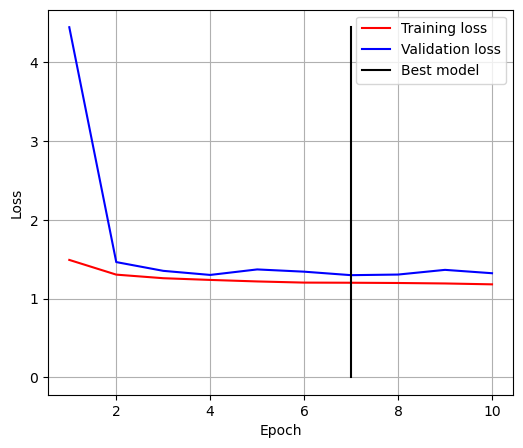

In [20]:
model_fe = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained = 'true')

for param in model_fe.parameters(): 
    param.requires_grad=False

num_classes = len(cifar_full.classes)
model_fe.classifier = nn.Sequential(
    model_fe.classifier,
    nn.ReLU(),
    nn.Linear(1000,num_classes)
)

#print(model_fe.parameters)
model_fe = model_fe.to(device)

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0
epochs = 10
criterion_fe = nn.CrossEntropyLoss()

optimizer_fe = optim.SGD(model_fe.parameters(), LEARNING_RATE, weight_decay = WEIGHT_DECAY) 

# Train the model
trained_model_fe = train_model(model_fe, criterion_fe, optimizer_fe, train_loader, validation_loader, epochs,1)

# Test the model
tested_model = copy.deepcopy(trained_model_fe)


In [21]:
#Accuracies:
accuracy = accuracy_func(train_loader, tested_model)
print(f'Accuracy, dataset_train: {accuracy*1e2}%')

accuracy = accuracy_func(validation_loader, tested_model)
print(f'Accuracy, dataset_validation: {accuracy*1e2}%')

accuracy = accuracy_func(test_loader, tested_model)
print(f'Accuracy, dataset_test: {accuracy*1e2}%')

Accuracy, dataset_train: 59.0375%
Accuracy, dataset_validation: 57.32000000000001%
Accuracy, dataset_test: 56.66%


## 0.2.2 Transfer Learning from MNIST

In [22]:
# Define the mini-batch size
batch_size = 5000

# Download the dataset and create the dataloaders
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.1307], std=[0.3081]),
    ])
#Load all train:
mnist_full = datasets.MNIST("./", train=True, download=True, transform=transform)

#Split training, validation
mnist_train, mnist_validation = torch.utils.data.random_split(mnist_full, [0.8, 0.2])
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=False)
batch_size_validation = len(mnist_validation)
validation_loader = DataLoader(mnist_validation, batch_size=batch_size_validation, shuffle=False)

#Load test:
mnist_test = datasets.MNIST("./", train=False, download=True, transform=transform)
batch_size_test = len(mnist_test)
test_loader = DataLoader(mnist_test, batch_size=batch_size_test, shuffle=False)

print('Length training set: ', len(mnist_train))
print('Length validation set: ', len(mnist_validation))
print('Length test set: ', len(mnist_test))

def plot_image2(image):
    image = np.transpose(image,[1,2,0])
    #print(image.shape)
    plt.figure(figsize=(1,1))
    plt.imshow(image,cmap='gray')
    plt.show()

Length training set:  48000
Length validation set:  12000
Length test set:  10000


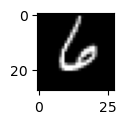

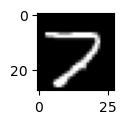

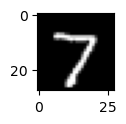

In [23]:
images,labels = next(iter(train_loader))
i = 2
plot_image2(images[i])
#print(torch.min(images),torch.max(images))
#print(images[i])
#print(labels[i])
#print(images[i].shape)


images,labels = next(iter(validation_loader))
plot_image2(images[0])
#print(images[0].shape)

images,labels = next(iter(test_loader))
plot_image2(images[0])


In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 2)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 10)
        #self.leaky_relu = nn.LeakyReLU()
        self.relu = nn.ReLU()
    def forward(self, x):
        # Implement the forward function in the network
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        #print(x.shape)
        x = x.view(-1,16*6*6)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)

def train_model(model, criterion, optimizer, train_loader, validation_loader, num_epochs):
    min_validation_loss = 10000    
    # Store training and validation loss
    training_loss, validation_loss = [], []
    for i in range(epochs):
        
        epoch_validation_loss = 0
        for batch_nr, (images, labels) in enumerate(validation_loader):
        
            labels = to_onehot(labels)
            
            images, labels = images.to(device), labels.to(device)
        
            prediction = model.forward(images)
            
            loss = criterion(prediction, labels)

            epoch_validation_loss += loss.item()
            
        validation_loss.append(epoch_validation_loss/(batch_nr+1))

        if validation_loss[i] < min_validation_loss:
            min_validation_loss = validation_loss[i]
            optModel = copy.deepcopy(model)
            minValLossEpoch = i
            #print(i)

        k = 0
        epoch_training_loss = 0
        for batch_nr, (images, labels) in enumerate(train_loader):
            k += 1
            labels = to_onehot(labels)
            
            images, labels = images.to(device), labels.to(device)

            prediction = model.forward(images)

            loss = criterion(prediction, labels)

            loss.backward()

            optimizer.step()

            optimizer.zero_grad()

            epoch_training_loss += loss.item()
            
        training_loss.append(epoch_training_loss/k)
        
        if i % 10 == 0:
            print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')
            
    plt.figure(figsize=(6,5))
    plt.plot(range(1,epochs+1), training_loss, 'r', label='Training loss',)
    plt.plot(range(1,epochs+1), validation_loss, 'b', label='Validation loss')
    plt.plot((minValLossEpoch+1,minValLossEpoch+1),(0,max(training_loss+validation_loss)),'k-',label='Best model') 
    plt.legend()
    plt.xlabel('Epoch'), plt.ylabel('Loss')
    plt.grid()
    #plt.ylim((0, 1)) 
    plt.show()
    return optModel


Epoch 0, training loss: 2.27350652217865, validation loss: 2.305875301361084
Epoch 10, training loss: 0.3875434368848801, validation loss: 0.40232715010643005
Epoch 20, training loss: 0.23583174645900726, validation loss: 0.2442651391029358
Epoch 30, training loss: 0.16644066870212554, validation loss: 0.1762930005788803
Epoch 40, training loss: 0.12794984355568886, validation loss: 0.1396661400794983
Epoch 50, training loss: 0.10455109551548958, validation loss: 0.11709434539079666
Epoch 60, training loss: 0.08895378783345223, validation loss: 0.10323765873908997
Epoch 70, training loss: 0.07754525914788246, validation loss: 0.09344688802957535
Epoch 80, training loss: 0.06818245574831963, validation loss: 0.08522022515535355
Epoch 90, training loss: 0.06044813357293606, validation loss: 0.0795062705874443


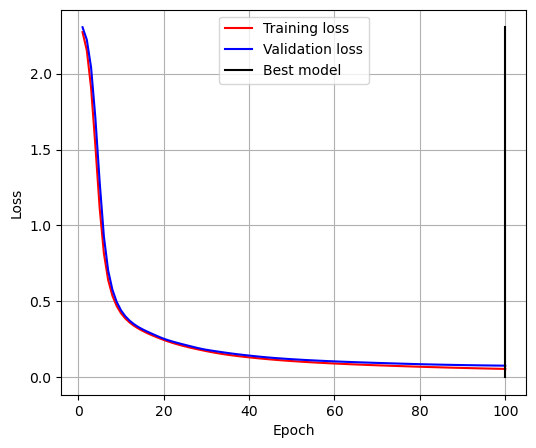

In [26]:
#Hyperparameters
epochs = 100
SHUFFLE = False
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0

# Load our network
model = Net().to(device)

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer
optimizer = optim.Adam(model.parameters(), LEARNING_RATE, weight_decay = WEIGHT_DECAY) #Weight_decay motsvarar lambda i L2norm-regularization

# Train the model
trained_model = train_model(model, criterion, optimizer, train_loader, validation_loader, epochs)

# Test the model
tested_model = copy.deepcopy(trained_model)

In [27]:
#Accuracies:
accuracy = accuracy_func(train_loader, tested_model)
print(f'Accuracy, dataset_train: {accuracy*1e2}%')

accuracy = accuracy_func(validation_loader, tested_model)
print(f'Accuracy, dataset_validation: {accuracy*1e2}%')

accuracy = accuracy_func(test_loader, tested_model)
print(f'Accuracy, dataset_test: {accuracy*1e2}%')

Accuracy, dataset_train: 98.31041666666667%
Accuracy, dataset_validation: 97.78333333333333%
Accuracy, dataset_test: 98.00999999999999%


In [3]:
# Define the mini-batch size
batch_size = 5000

# Download the dataset and create the dataloaders
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=1),
    transforms.CenterCrop((28,28))
    ])
#Load all train:
svhn_full = datasets.SVHN("./", split='train', download=True, transform=transform)

#Split training, validation
svhn_train, svhn_validation = torch.utils.data.random_split(svhn_full, [0.8, 0.2])
train_loader = DataLoader(svhn_train, batch_size=batch_size, shuffle=False)
batch_size_validation = len(svhn_validation)
validation_loader = DataLoader(svhn_validation, batch_size=batch_size_validation, shuffle=False)

#Load test:
svhn_test = datasets.SVHN("./", split='test', download=True, transform=transform)
batch_size_test = len(svhn_test)
test_loader = DataLoader(svhn_test, batch_size=batch_size_test, shuffle=False)

print('Length training set: ', len(svhn_train))
print('Length validation set: ', len(svhn_validation))
print('Length test set: ', len(svhn_test))
#print('Number of classes: ', len(svhn_full.classes))

Using downloaded and verified file: ./train_32x32.mat
Using downloaded and verified file: ./test_32x32.mat
Length training set:  58606
Length validation set:  14651
Length test set:  26032


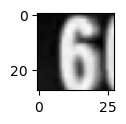

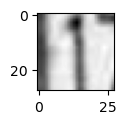

tensor(1)


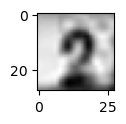

tensor(2)


In [29]:
images,labels = next(iter(train_loader))
i = 1
plot_image2(images[i])
#print(torch.min(images),torch.max(images))
#print(images[i])
# print(labels[i])
# print(images[i].shape)


images,labels = next(iter(validation_loader))
plot_image2(images[i])
print(labels[i])
#print(images[0].shape)

images,labels = next(iter(test_loader))
plot_image2(images[i])
print(labels[i])


In [30]:
#Accuracies:
accuracy = accuracy_func(train_loader, tested_model)
print(f'Accuracy, dataset_train: {accuracy*1e2}%')

accuracy = accuracy_func(validation_loader, tested_model)
print(f'Accuracy, dataset_validation: {accuracy*1e2}%')

accuracy = accuracy_func(test_loader, tested_model)
print(f'Accuracy, dataset_test: {accuracy*1e2}%')

Accuracy, dataset_train: 15.15032590519742%
Accuracy, dataset_validation: 15.20032762268787%
Accuracy, dataset_test: 15.361862323294407%


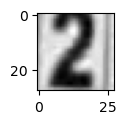

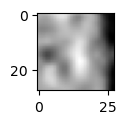

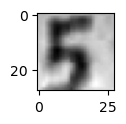

In [33]:
images,labels = next(iter(train_loader))
i = 0
plot_image2(images[i])
#print(images[i])
#print(labels[i])
#print(images[i].shape)


images,labels = next(iter(validation_loader))
plot_image2(images[0])
#print(images[0].shape)

images,labels = next(iter(test_loader))
plot_image2(images[0])
